In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression

In [3]:
with open('location.pickle','rb') as read_file:
    location = pickle.load(read_file)

In [4]:
location.longitude.max()

-71.475604

In [5]:
train, val = train_test_split(location, test_size=0.2, random_state=42)

In [6]:
train = train[train.longitude < -82]
train.head()

,longitude,latitude,status
485631,-87.694659,41.844496,1
271252,-87.626369,41.874254,1
409475,-87.638620,41.922176,1
147799,-87.630906,41.883360,0
675164,-87.644393,41.935019,1


In [7]:

lm_loc = LogisticRegression(solver='newton-cg', C=10) 
lm_loc.fit(train[['latitude','longitude']], train['status'])

# We can see that the coefficient in question matches the one from statsmodels
print('intercept: ', round(lm_loc.intercept_[0], 4))
print('coef: ', round(lm_loc.coef_[0][0], 4))

C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


intercept:  10.3247
coef:  3.7152


C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [ ]:
train.status.value_counts()

## Seaborn plots worked well on initial pull of data, but too slow on full data set

In [ ]:
# sns.violinplot(x='longitude',
#                y='status',
#                data=train);

In [ ]:
# sns.violinplot(x='latitude',
#                y='status',
#                data=train);

In [ ]:
# sns.scatterplot(data=train,
#                 x='latitude',
#                 y='longitude',
#                 hue='status');

In [8]:
val_c = val.copy()
val_c['pred'] = lm_loc.predict(val[['latitude','longitude']])
val_c.loc[:, 'pred'] = val_c['pred'].astype('category')
val_c['correct_pred'] = val_c['pred'] == val_c['status']

In [ ]:
# sns.stripplot(data=test_c,
#               x='latitude',
#               y='pred',
#               hue='correct_pred',
#               palette={False: '#f03b20', True: '#3182bd'});

In [9]:
# This is the same model but with proba (returns probabilities instead of class)
val_c['proba_paid'] = lm_loc.predict_proba(val_c[['latitude','longitude']])[:, 1]
val_c.head()


# fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
# fig.suptitle('Tickets paid predictions: latitude and longitude')
# axes[0].set_title('Latitude')
# axes[1].set_title('Longitude')

# sns.scatterplot(data=test_c,
#                 ax=axes[0],
#                 x='latitude',
#                 y='proba_paid',
#                 hue='paid',
#                 marker='|',
#                 s=200);
# sns.scatterplot(data=test_c,
#                 ax=axes[1],
#                 x='longitude',
#                 y='proba_paid',
#                 hue='paid',
#                 marker='|',
#                 s=200);

,longitude,latitude,status,pred,correct_pred,proba_paid
955613,-87.692567,41.997949,1,1,True,0.772438
977733,-87.690110,41.997878,1,1,True,0.773204
183470,-87.769756,41.869919,1,1,True,0.645912
339425,-87.671413,41.762894,1,1,True,0.595966
881536,-87.615536,41.838293,0,1,False,0.684392


In [10]:
cf_matrix = confusion_matrix(val_c['status'], val_c['pred'])
cf_matrix

array([[   15, 38571],
       [   13, 92931]], dtype=int64)

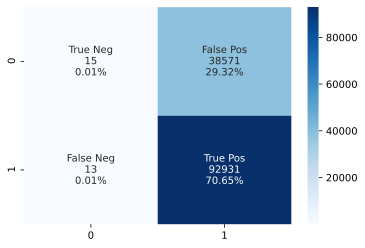

In [11]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
test_c['ticket_queue'].astype('int32').dtypes
mvp_eval['ticket_queue'].value_counts()

In [ ]:
lm_loc.predict_proba(val[['latitude','longitude']])[:5]

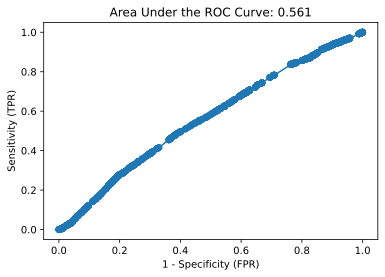

In [12]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");
    
fpr, tpr, thresholds = roc_curve(val_c['status'], val_c['proba_paid'])


plot_roc(val_c['status'], val_c['proba_paid'])

In [13]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(val_c['status'], val_c['pred']), precision_score(val_c['status'], val_c['pred']), 
                                                     recall_score(val_c['status'], val_c['pred']),f1_score(val_c['status'], val_c['pred'], zero_division=1)))

Accuracy: 0.7067, Precision: 0.7067,   Recall: 0.9999,   F1: 0.8281


In [14]:
mask = tpr > 0.9
thresholds[mask].max()


0.6609930262570531

## Multiple features: Logistic Regression

In [15]:
# with open('table.pickle','rb') as read_file:
#     data = pickle.load(read_file)
    
with open('train.pickle','rb') as read_file:
    data = pickle.load(read_file)
with open('test.pickle','rb') as read_file:
    test = pickle.load(read_file)
    
data.dropna(inplace=True)
low_train, data_val = train_test_split(data, test_size=0.2, random_state=42, stratify=data['status'])

In [ ]:
low_train.status.value_counts()

In [ ]:
df.to_csv()

In [16]:
from imblearn.over_sampling import RandomOverSampler

features = ['state', 'value','longitude','latitude']
X=low_train[features]
y=low_train['status']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [ ]:
# sns.scatterplot(data=mvp2_train,
#                 x='license_plate_state',
#                 y='fine_level1_amount',
#                 hue='ticket_queue');



In [17]:
# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_resampled)
y_train = y_resampled

In [18]:
lm_2 = LogisticRegression() 
lm_2.fit(X_train, y_train)

LogisticRegression()

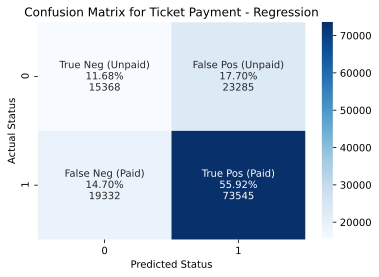

In [42]:
X_val = scaler.transform(data_val[features])
preds = lm_2.predict(X_val)

cf_matrix2 = confusion_matrix(data_val['status'], preds)


group_names = ['True Neg (Unpaid)','False Pos (Unpaid)','False Neg (Paid)','True Pos (Paid)']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap=plt.cm.Blues)
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix for Ticket Payment - Regression')
plt.show(g);

In [20]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'], preds),precision_score(data_val['status'], preds), 
                                                     recall_score(data_val['status'], preds),f1_score(data_val['status'], preds, zero_division=1)))

Accuracy: 0.6760, Precision: 0.7595,   Recall: 0.7919,   F1: 0.7754


## New model of Random Forest (TM)

In [21]:
from sklearn.ensemble import RandomForestClassifier
rc = RandomForestClassifier(n_estimators=100, max_features=4)
rc.fit(X,y)
y_hat_tr = rc.predict(X)
y_hat_te = rc.predict(data_val[features])
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],y_hat_te), precision_score(data_val['status'], y_hat_te), 
                                                     recall_score(data_val['status'], y_hat_te),f1_score(data_val['status'],y_hat_te, zero_division=1)))

Accuracy: 0.7199, Precision: 0.7374,   Recall: 0.9370,   F1: 0.8253


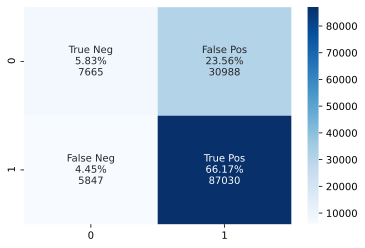

In [22]:
cf_matrixRF = confusion_matrix(data_val['status'], y_hat_te)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixRF.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixRF.flatten()/np.sum(cf_matrixRF)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixRF, annot=labels, fmt='', cmap=plt.cm.Blues);

## Attempting to run RFC on balanced data, just to see. Appears to have hurt recall, helped precision. Overall, lowered F1.

In [23]:
rf_bal = RandomForestClassifier(n_estimators=100, max_features=4)
rf_bal.fit(X_resampled,y_resampled)
pred_bal = rf_bal.predict(X_resampled)
pred_rf_bal = rf_bal.predict(data_val[features])
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],pred_rf_bal) ,precision_score(data_val['status'], pred_rf_bal), 
                                                     recall_score(data_val['status'], pred_rf_bal),f1_score(data_val['status'],pred_rf_bal, zero_division=1)))

Accuracy: 0.6540, Precision: 0.7840,   Recall: 0.7040,   F1: 0.7418


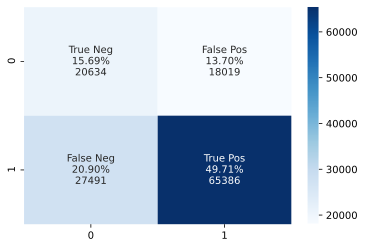

In [24]:
cf_matrix_rfbal = confusion_matrix(data_val['status'], pred_rf_bal)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix_rfbal.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix_rfbal.flatten()/np.sum(cf_matrix_rfbal)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_rfbal, annot=labels, fmt='', cmap=plt.cm.Blues);

## Checking ROC curve for balanced logistic regression, unbalanced small RFC, and unbalanced large RFC with all features

In [ ]:
# from sklearn.metrics import plot_roc_curve
# from sklearn.svm import SVC

# svc = SVC(random_state=42)
# svc.fit(X_train, y_train)
# svc_disp = plot_roc_curve(svc, data_val[features], data_val['status'])
# plt.show()

NameError: name 'forest' is not defined

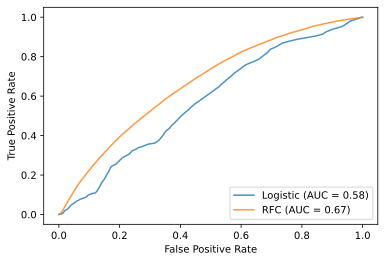

In [25]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
lm_disp = plot_roc_curve(lm_2, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='Logistic')
rc_disp = plot_roc_curve(rc, data_val[features], data_val['status'], ax=ax, alpha=0.8, name='RFC')
rf_disp = plot_roc_curve(forest, X_val, data_val['status'], ax=ax, alpha=0.8, name='RFC-Viol')
gbm_disp = plot_roc_curve(gbm, test[features].astype('float64'), test['status'].astype('float64'),  ax=ax, alpha=0.8, name='GBM')
# lm_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Random Forest With Violation Codes

In [26]:
X_big = low_train.drop(columns=['status'])
X_val = data_val.drop(columns=['status'])
y.describe()

count    526118.000000
mean          0.706132
std           0.455532
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: status, dtype: float64

In [27]:
low_train.head()

,status,state,code_0724225,code_0724226,code_0728440,code_0808060,code_0816020,code_0820015,code_0912060,code_0940060,...,code_0980110,code_0980120,code_0980130,code_0980220,code_1141115,code_1520270,hearing,value,longitude,latitude
832539,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,50,-87.898200,41.981800
202031,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,25,-87.622451,41.892782
615443,0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,50,-87.783472,41.894799
96632,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,50,-87.551257,41.729925
962624,1,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,50,-87.627542,41.893634


In [28]:
forest = RandomForestClassifier(n_estimators=100, max_features=10)
forest.fit(X_big,y)
rf_preds= forest.predict(X_big)
rf_val_preds = forest.predict(X_val)

In [29]:
print("Accuracy: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(accuracy_score(data_val['status'],rf_val_preds), precision_score(data_val['status'],rf_val_preds), 
                                                     recall_score(data_val['status'],rf_val_preds),f1_score(data_val['status'],rf_val_preds, zero_division=1)))

Accuracy: 0.7218, Precision: 0.7424,   Recall: 0.9280,   F1: 0.8249


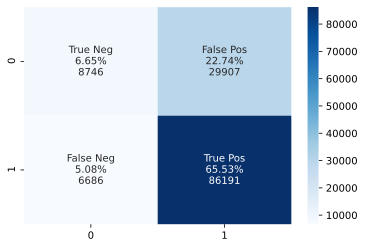

In [30]:
cf_mat = confusion_matrix(data_val['status'],rf_val_preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues);

<BarContainer object of 10 artists>

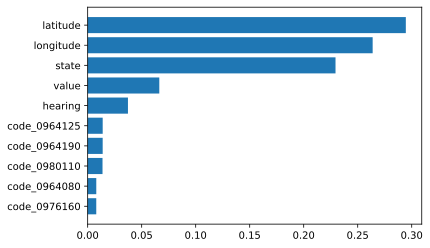

In [31]:
from sklearn.inspection import permutation_importance
sorted_idx = forest.feature_importances_.argsort()[-10:]
plt.barh(X_big.columns[sorted_idx], forest.feature_importances_[sorted_idx])

## K Nearest Neighbors Models

In [ ]:
import itertools
from sklearn import metrics
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.neighbors import KNeighborsClassifier


### Let's take a quick look at a KNN model based on the four closest neighbors

### DO NOT RUN UNLESS YOU WANT TO WAIT 30 MINUTES

In [ ]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_resampled,y_resampled)
yhat = neigh.predict(data_test[features])
print("Train set Accuracy: ", metrics.accuracy_score(y_resampled, neigh.predict(X_resampled)))
print("Test set Accuracy: ", metrics.accuracy_score(data_test['status'], yhat))

### Diving deeper and evaluating other KNN across values of k and multiple metrics

### DO NOT RUN UNLESS YOU WANT TO WAIT 10 YEARS

In [ ]:
Ks = 10
mean_acc = np.zeros((Ks-1))
mean_f1 = np.zeros((Ks-1))
mean_prec = np.zeros((Ks-1))
mean_recall = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_resampled,y_resampled)
    yhat = neigh.predict(data_test[features])
    mean_acc[n-1] = metrics.accuracy_score(data_test['status'], yhat)
    mean_f1[n-1]= f1_score(data_test['status'], yhat, zero_division=1)
    mean_prec[n-1] = precision_score(data_test['status'], yhat)
    mean_recall[n-1] = recall_score(data_test['status'], yhat)
    
    
#     std_acc[n-1]=np.std(yhat==data_test['status'])/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.plot(range(1,Ks),mean_f1,'b')
plt.plot(range(1,Ks),mean_prec,'r')
plt.plot(range(1,Ks),mean_recall,'y')
# plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_f1 - 1 * std_acc,mean_f1+ 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_prec - 1 * std_acc,mean_prec+ 1 * std_acc, alpha=0.10)
# plt.fill_between(range(1,Ks),mean_recall - 1 * std_acc,mean_recall+ 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ','F1','Precision','Recall'))
plt.ylabel('Metrics')
plt.xlabel('Number of Nabors (K)')
plt.title('Accuracy, F1, Precision, and Reall scores for KNN across many values of k')
plt.tight_layout()
plt.show()

In [ ]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print( "The best F1 Score was with", mean_f1.max(), "with k=", mean_f1.argmax()+1) 
print( "The best precision was with", mean_prec.max(), "with k=", mean_prec.argmax()+1) 
print( "The best recall was with", mean_recall.max(), "with k=", mean_recall.argmax()+1) 

## XGBOOST AREA

In [32]:
import xgboost as xgb

In [40]:
data_val['status'].dtypes

dtype('int32')

In [33]:
X_resampled.value = X_resampled.value.astype('float64')
y_resampled = y_resampled.astype('float64')
data_val[features] = data_val[features].astype('float64')
data_val['status'] = data_val['status'].astype('float64')

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-33-2c5e76c6bf55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['status'] = data_val['status'].astype('float64')


In [34]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8
        )

eval_set=[(X_resampled,y_resampled),(data_val[features],data_val['status'])]

fit_model = gbm.fit(
                X_resampled, y_resampled, 
                eval_set=eval_set,
                eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

acc = accuracy_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
rec = recall_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
prec = precision_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
f1 = f1_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
print('Accuracy: ',acc, '\n','Recall: ',rec, '\n','Precision: ',prec, '\n','f1 score: ',f1)

Accuracy:  0.6496172222660684 
 Recall:  0.6930799910219444 
 Precision:  0.7836811588544209 
 f1 score:  0.73560132671199


In [ ]:
acc = accuracy_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
rec = recall_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
prec = precision_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
f1 = f1_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
print('Accuracy: ',acc, '\n','Recall: ',rec, '\n','Precision: ',prec, '\n','f1 score: ',f1)

In [35]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8
        )

eval_set=[(X_resampled,y_resampled),(data_val[features],data_val['status'])]

fit_model = gbm.fit(
                X_resampled, y_resampled, 
                eval_set=eval_set,
                eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
recall_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
precision_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
f1_score(test['status'].astype('float64'), gbm.predict(test[features].astype('float64'), ntree_limit=gbm.best_ntree_limit))
print('Accuracy: ',acc, '\n','Recall: ',rec, '\n','Precision: ',prec, '\n','f1 score: ',f1)

Accuracy:  0.6496172222660684 
 Recall:  0.6930799910219444 
 Precision:  0.7836811588544209 
 f1 score:  0.73560132671199


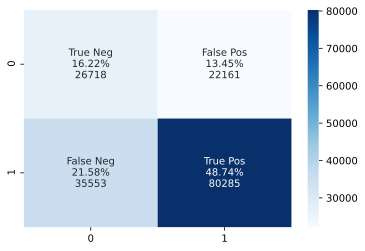

In [36]:
cf_mat = confusion_matrix(test['status'].astype('float64'),gbm.predict(test[features].astype('float64')))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues);

In [37]:
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV   #Additional scklearn functions


In [38]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = dtrain.astype('float64')
        xgtrain = xgb.DMatrix(dtrain[predictors], label=dtrain[target])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("f1 : %.4g" % f1_score(dtrain[target], dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


C:\Users\ejfel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
f1 : 0.8331
AUC Score (Train): 0.699901


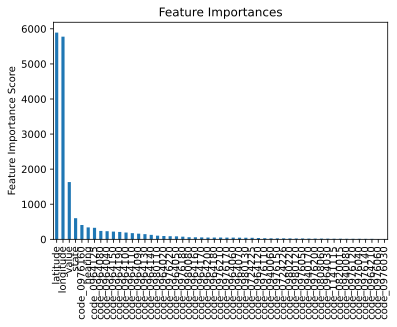

In [39]:
predictors = [x for x in low_train.columns if x not in ['status']]
target = 'status'
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, low_train, predictors)

In [48]:
preds = [x for x in low_train.columns if x not in ['status']]
preds

['state',
 'code_0724225',
 'code_0724226',
 'code_0728440',
 'code_0808060',
 'code_0816020',
 'code_0820015',
 'code_0912060',
 'code_0940060',
 'code_0940080',
 'code_0940170',
 'code_0940220',
 'code_0964020',
 'code_0964030',
 'code_0964040',
 'code_0964050',
 'code_0964060',
 'code_0964070',
 'code_0964080',
 'code_0964090',
 'code_0964091',
 'code_0964100',
 'code_0964110',
 'code_0964120',
 'code_0964125',
 'code_0964130',
 'code_0964140',
 'code_0964150',
 'code_0964160',
 'code_0964170',
 'code_0964180',
 'code_0964190',
 'code_0964200',
 'code_0964210',
 'code_0976010',
 'code_0976020',
 'code_0976030',
 'code_0976040',
 'code_0976050',
 'code_0976060',
 'code_0976070',
 'code_0976080',
 'code_0976090',
 'code_0976100',
 'code_0976110',
 'code_0976120',
 'code_0976130',
 'code_0976140',
 'code_0976150',
 'code_0976160',
 'code_0976170',
 'code_0976180',
 'code_0976200',
 'code_0976210',
 'code_0976220',
 'code_0980080',
 'code_0980110',
 'code_0980120',
 'code_0980130',
 'co

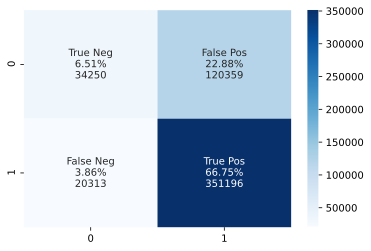

In [50]:
preds = [x for x in low_train.columns if x not in ['status']]
cf_mat = confusion_matrix(low_train['status'].astype('float64'), xgb1.predict(low_train[preds].astype('float64')))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt='', cmap=plt.cm.Blues);

# Scoring on TEST DATA

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rc = RandomForestClassifier(n_estimators=100, max_features=4)
rc.fit(X,y)
y_hat_tr = rc.predict(X)
y_hat_te = rc.predict(data_test[features])
print("Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(precision_score(data_test['status'], y_hat_te), 
                                                     recall_score(data_test['status'], y_hat_te),f1_score(data_test['status'],y_hat_te, zero_division=1)))

In [ ]:
cf_matrixRF = confusion_matrix(data_test['status'], y_hat_te)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixRF.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixRF.flatten()/np.sum(cf_matrixRF)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixRF, annot=labels, fmt='', cmap=plt.cm.Blues);

In [ ]:
# fpr, tpr, thresholds = roc_curve(mvp2_eval['in_sf'],
#                                  df_eval['proba_sf'])


# Random stuff, remove later

In [ ]:
from sklearn.datasets import load_breast_cancer
bc_dataset = load_breast_cancer()
X = pd.DataFrame(bc_dataset.data)
X.columns = bc_dataset.feature_names
y = bc_dataset.target

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [ ]:
X_val.dtypes

In [ ]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

In [ ]:
test.head(20)